In [33]:
#pip install kagglehub


In [34]:
#pip install tensorflow

# Libraries

In [35]:
import matplotlib.pyplot as plt
import kagglehub
import os, random
import xml.etree.ElementTree as ET
import cv2
from tqdm import tqdm
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report


# Import Data

In [ ]:
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\delha\.cache\kagglehub\datasets\andrewmvd\face-mask-detection\versions\1


Checking size annotations & images

In [ ]:
DATASET_PATH = r"C:\Users\delha\.cache\kagglehub\datasets\andrewmvd\face-mask-detection\versions\1"

print(os.listdir(DATASET_PATH))
print("images:", len(os.listdir(os.path.join(DATASET_PATH, "images"))))
print("annotations:", len(os.listdir(os.path.join(DATASET_PATH, "annotations"))))


['annotations', 'faces', 'images']
images: 853
annotations: 853


# Test random images dataset

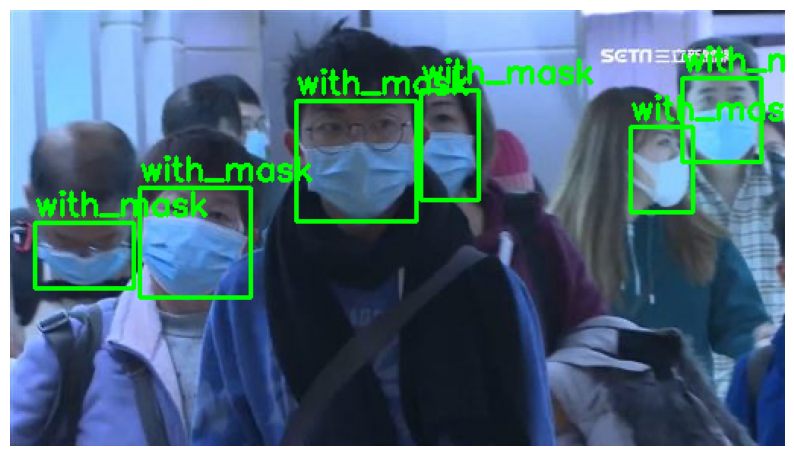

XML: maksssksksss573.xml | Image: maksssksksss573.png


In [ ]:
IMG_DIR = os.path.join(DATASET_PATH, "images")
ANN_DIR = os.path.join(DATASET_PATH, "annotations")

xml_file = random.choice([f for f in os.listdir(ANN_DIR) if f.endswith(".xml")])
img_file = xml_file.replace(".xml", ".png")  

img_path = os.path.join(IMG_DIR, img_file)
if not os.path.exists(img_path):
    img_file = xml_file.replace(".xml", ".jpg")
    img_path = os.path.join(IMG_DIR, img_file)

tree = ET.parse(os.path.join(ANN_DIR, xml_file))
root = tree.getroot()

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

for obj in root.findall("object"):
    label = obj.find("name").text
    b = obj.find("bndbox")
    xmin, ymin = int(b.find("xmin").text), int(b.find("ymin").text)
    xmax, ymax = int(b.find("xmax").text), int(b.find("ymax").text)
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    cv2.putText(img, label, (xmin, max(0, ymin-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

plt.figure(figsize=(10,6))
plt.imshow(img)
plt.axis("off")
plt.show()

print("XML:", xml_file, "| Image:", img_file)


In [39]:
"""""

import shutil, os
if os.path.exists(OUT_DIR):
    shutil.rmtree(OUT_DIR)
os.makedirs(OUT_DIR, exist_ok=True) """""


'""\n\nimport shutil, os\nif os.path.exists(OUT_DIR):\n    shutil.rmtree(OUT_DIR)\nos.makedirs(OUT_DIR, exist_ok=True) '

# Resizing images and reduce to 2 class

In [ ]:
DATASET_PATH = r"C:\Users\delha\.cache\kagglehub\datasets\andrewmvd\face-mask-detection\versions\1"
IMG_DIR = os.path.join(DATASET_PATH, "images")
ANN_DIR = os.path.join(DATASET_PATH, "annotations")

OUT_DIR = os.path.join(DATASET_PATH, "faces")  # on reste dans le même dossier
os.makedirs(OUT_DIR, exist_ok=True)

classes = ["with_mask", "without_mask"]
label_map = {
    "with_mask": "with_mask",
    "without_mask": "without_mask",
    "mask_weared_incorrect": "without_mask"  # <-- fusion ici
}

for c in classes:
    os.makedirs(os.path.join(OUT_DIR, c), exist_ok=True)

def find_image_for_xml(xml_filename):
    base = xml_filename.replace(".xml", "")
    for ext in [".png", ".jpg", ".jpeg"]:
        p = os.path.join(IMG_DIR, base + ext)
        if os.path.exists(p):
            return p
    return None

saved = 0
skipped = 0

for xml_file in tqdm([f for f in os.listdir(ANN_DIR) if f.endswith(".xml")]):
    img_path = find_image_for_xml(xml_file)
    if img_path is None:
        skipped += 1
        continue

    img = cv2.imread(img_path)
    if img is None:
        skipped += 1
        continue

    h, w = img.shape[:2]
    tree = ET.parse(os.path.join(ANN_DIR, xml_file))
    root = tree.getroot()

    base = os.path.splitext(os.path.basename(img_path))[0]

    obj_idx = 0
    for obj in root.findall("object"):
        label_raw = obj.find("name").text.strip()
        if label_raw not in label_map:
            continue
        label = label_map[label_raw]   # <-- ici on fusionne incorrect -> without_mask


        b = obj.find("bndbox")
        xmin = max(0, int(b.find("xmin").text))
        ymin = max(0, int(b.find("ymin").text))
        xmax = min(w - 1, int(b.find("xmax").text))
        ymax = min(h - 1, int(b.find("ymax").text))

        if xmax <= xmin or ymax <= ymin:
            continue

        crop = img[ymin:ymax, xmin:xmax]

        # petit nettoyage: ignorer crops trop petits
        if crop.shape[0] < 32 or crop.shape[1] < 32:
            continue

        out_name = f"{base}_{obj_idx}.jpg"
        out_path = os.path.join(OUT_DIR, label, out_name)

        cv2.imwrite(out_path, crop)
        saved += 1
        obj_idx += 1

print("crops sauvegardés:", saved)
print("xml/images ignorés:", skipped)
print("dossier:", OUT_DIR)


100%|██████████| 853/853 [00:10<00:00, 81.97it/s]

✅ crops sauvegardés: 1197
⚠️ xml/images ignorés: 0
📁 dossier: C:\Users\delha\.cache\kagglehub\datasets\andrewmvd\face-mask-detection\versions\1\faces


# Model

ResNet-50 backbone + Global Average Pooling + Dropout + Softmax classifier.

In [47]:
DATASET_PATH = r"C:\Users\delha\.cache\kagglehub\datasets\andrewmvd\face-mask-detection\versions\1"
faces_dir = os.path.join(DATASET_PATH, "faces")

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    faces_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    faces_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size)

class_names = train_ds.class_names
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Base model: ResNet-50
base = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))


x = tf.keras.applications.resnet.preprocess_input(inputs)

x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)  
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Found 1197 files belonging to 2 classes.
Using 958 files for training.
Found 1197 files belonging to 2 classes.
Using 239 files for validation.
Classes: ['with_mask', 'without_mask']
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8346 - loss: 0.5307 - val_accuracy: 0.9582 - val_loss: 0.1544
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9375 - loss: 0.1902 - val_accuracy: 0.9623 - val_loss: 0.1167
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9477 - loss: 0.1439 - val_accuracy: 0.9665 - val_loss: 0.0993
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9640 - loss: 0.1061 - val_accuracy: 0.9665 - val_loss: 0.0938
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9662 - loss: 0.0810 - val_accuracy: 0.9707 - val_loss: 0.0848
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9734 - loss: 0.0673 - val_accuracy: 0.9791 - val_loss: 0.0798
Epoch 7/10

# Output

Confusion Matrix

In [48]:
y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)

y_pred_probs = model.predict(val_ds, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(class_names)).numpy()

print("Confusion matrix:\n", cm)


Confusion matrix:
 [[158  33]
 [ 36  12]]


In [49]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


              precision    recall  f1-score   support

   with_mask     0.8144    0.8272    0.8208       191
without_mask     0.2667    0.2500    0.2581        48

    accuracy                         0.7113       239
   macro avg     0.5405    0.5386    0.5394       239
weighted avg     0.7044    0.7113    0.7078       239



Accuracy & Loss courbe

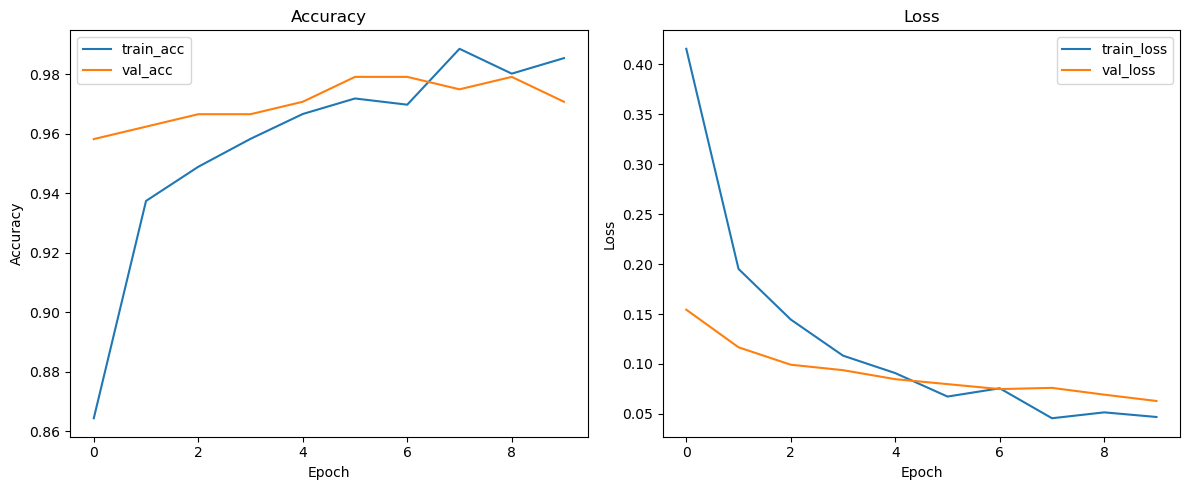

In [50]:
history_dict = history.history

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_dict["accuracy"], label="train_acc")
plt.plot(history_dict["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_dict["loss"], label="train_loss")
plt.plot(history_dict["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()


Images check

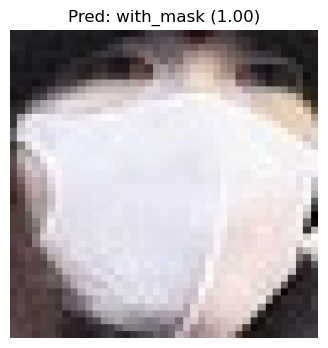

In [51]:
img_path = r"C:\Users\delha\.cache\kagglehub\datasets\andrewmvd\face-mask-detection\versions\1\faces\with_mask\maksssksksss0_0.jpg"

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)[None, ...]

pred = model.predict(x, verbose=0)[0]
pred_id = int(np.argmax(pred))
pred_label = class_names[pred_id]
pred_conf = float(np.max(pred))

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title(f"Pred: {pred_label} ({pred_conf:.2f})")
plt.axis("off")
plt.show()


Nb erreurs: 7


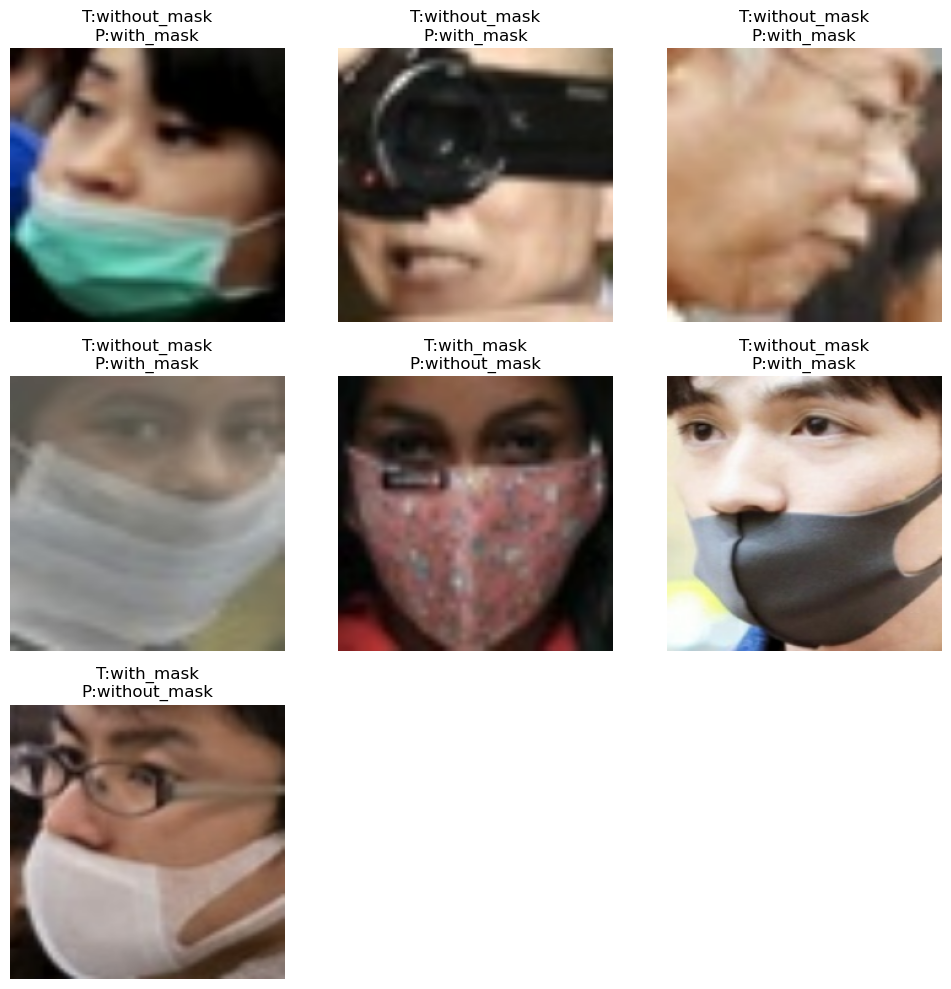

In [52]:
# récupérer aussi les images du val_ds
val_images = []
val_labels = []
for batch_x, batch_y in val_ds:
    val_images.append(batch_x.numpy())
    val_labels.append(batch_y.numpy())

val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# prédire sur ces images
preds = model.predict(val_images, verbose=0)
pred_ids = np.argmax(preds, axis=1)

wrong = np.where(pred_ids != val_labels)[0]
print("Nb erreurs:", len(wrong))

# afficher 9 erreurs
plt.figure(figsize=(10,10))
for i, idx in enumerate(wrong[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(val_images[idx].astype("uint8"))
    plt.title(f"T:{class_names[val_labels[idx]]}\nP:{class_names[pred_ids[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
